In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

In [4]:
waves = pd.read_csv('Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv')
waves.head()

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,01/01/2017 00:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
1,01/01/2017 00:30,0.875,1.39,4.421,4.506,-99.9,-99.90
2,01/01/2017 01:00,0.763,1.15,4.520,5.513,49.0,25.65
3,01/01/2017 01:30,0.770,1.41,4.582,5.647,75.0,25.50
4,01/01/2017 02:00,0.747,1.16,4.515,5.083,91.0,25.45


In [5]:
waves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43728 entries, 0 to 43727
Data columns (total 7 columns):
Date/Time         43728 non-null object
Hs                43728 non-null float64
Hmax              43728 non-null float64
Tz                43728 non-null float64
Tp                43728 non-null float64
Peak Direction    43728 non-null float64
SST               43728 non-null float64
dtypes: float64(6), object(1)
memory usage: 2.3+ MB


In [42]:
waves_clean = waves[(waves['Hs'] > 0) 
                    & (waves['Hmax'] > 0) 
                    & (waves['Tz'] > 0) 
                    & (waves['Tp'] > 0) 
                    & (waves['Peak Direction'] > 0) 
                    & (waves['SST'] > 0)].copy()

In [43]:
waves_clean['Date/Time'] = pd.to_datetime(waves_clean['Date/Time'])

In [44]:
waves_clean['Day Of Year'] = waves_clean['Date/Time'].dt.dayofyear
waves_clean.head()

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST,Day Of Year,Hour Of Year,Minute Of Year
2,2017-01-01 01:00:00,0.763,1.15,4.520,5.513,49.0,25.65,1,25,1500
3,2017-01-01 01:30:00,0.770,1.41,4.582,5.647,75.0,25.50,1,55,1530
4,2017-01-01 02:00:00,0.747,1.16,4.515,5.083,91.0,25.45,1,26,1560
5,2017-01-01 02:30:00,0.718,1.61,4.614,6.181,68.0,25.45,1,56,1590
6,2017-01-01 03:00:00,0.707,1.34,4.568,4.705,73.0,25.50,1,27,1620


In [45]:
waves['Minute Of Year'] = waves['Date/Time'].dt.hour * 60 + waves['Day Of Year'] * 24  * 60 + waves['Date/Time'].dt.minute
waves.head()

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST,Day Of Year,Hour Of Year,Minute Of Year
0,2017-01-01 00:00:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90,1,24,1440
1,2017-01-01 00:30:00,0.875,1.39,4.421,4.506,-99.9,-99.90,1,54,1470
2,2017-01-01 01:00:00,0.763,1.15,4.520,5.513,49.0,25.65,1,25,1500
3,2017-01-01 01:30:00,0.770,1.41,4.582,5.647,75.0,25.50,1,55,1530
4,2017-01-01 02:00:00,0.747,1.16,4.515,5.083,91.0,25.45,1,26,1560


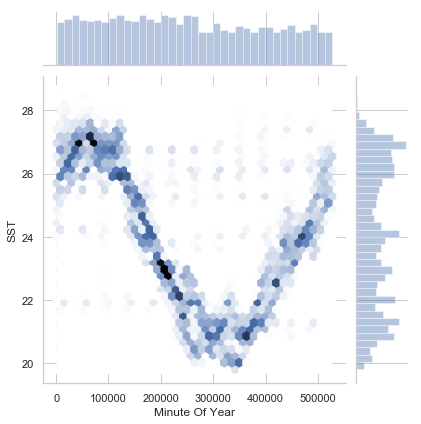

In [46]:
sns.jointplot(x='Minute Of Year',y='SST',data=waves_clean,kind='hex')

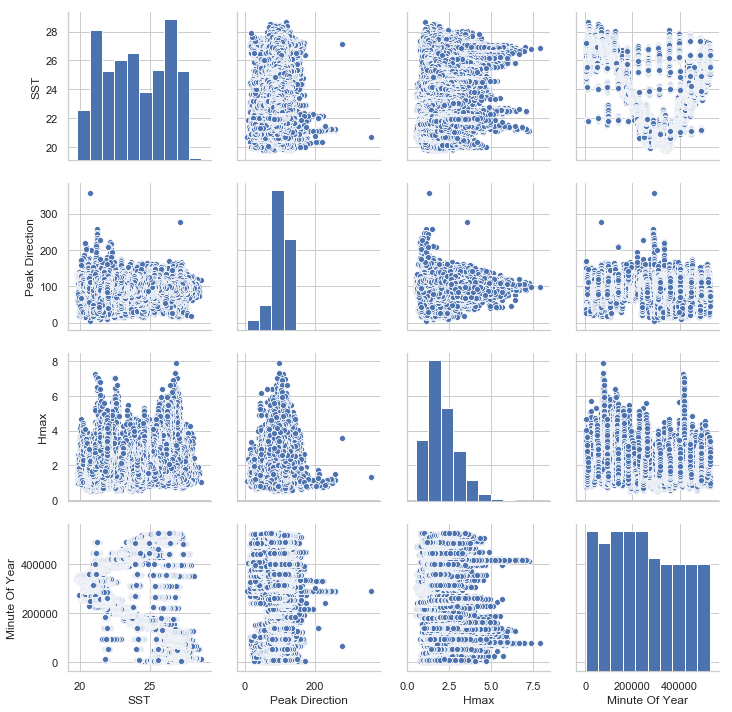

In [47]:
sns.pairplot(waves_clean,vars=['SST','Peak Direction','Hmax','Minute Of Year'])

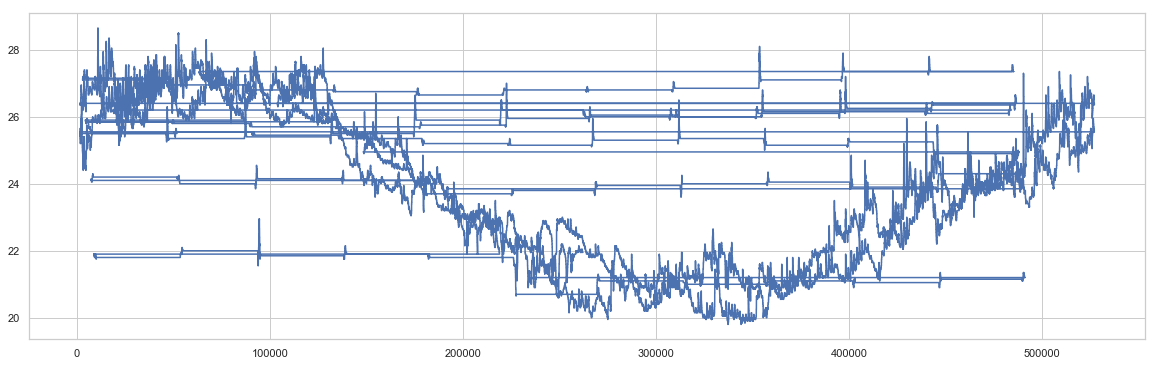

In [75]:
fig, ax = plt.subplots(figsize=(20,6))
ax.step(waves_clean['Minute Of Year'],waves_clean['SST'])

In [51]:
from sklearn.model_selection import train_test_split

In [129]:
target_name = 'SST'
X = waves_clean.drop(['Date/Time','Day Of Year','Hour Of Year', target_name],axis=1)
y = waves_clean[target_name]

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [131]:
import xgboost as xgb

In [132]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=200, 
                             learning_rate=0.2, 
                             gamma=0, 
                             subsample=0.75,
                             colsample_bytree=1,
                             max_depth=7)

In [133]:
xgb_model.fit(X_train,y_train)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.2, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.75, verbosity=1)

In [134]:
predictions = xgb_model.predict(X_test)

In [135]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print(metrics.explained_variance_score(y_test, predictions))

MAE: 0.2040346594047737
MSE: 0.10433738808160686
RMSE: 0.32301298438546844
0.9792800403719739


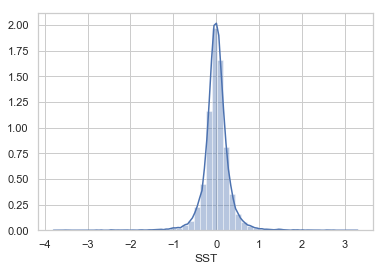

In [136]:
sns.distplot((y_test-predictions),bins=50);